In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
import tensorflow_addons as tfa

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 127s 1us/step


In [3]:
num_classes = 10
input_shape = (32, 32, 3)

In [4]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [19]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
data_augmentation = tf.keras.Sequential(
    
    [
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

### Multi Layer Perceptron

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

### Patch layer

In [14]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


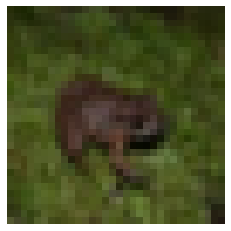

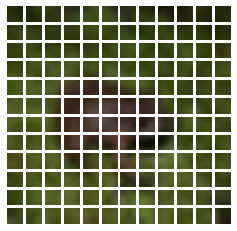

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [20]:
vit_classifier = create_vit_classifier()

In [21]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
______________________________________________________________________________________________

In [22]:
history = run_experiment(vit_classifier)

Epoch 1/10
1407/1407 [==============================] - 191s 130ms/step - loss: 3.0678 - accuracy: 0.1491 - top-5-accuracy: 0.6216 - val_loss: 2.0207 - val_accuracy: 0.2252 - val_top-5-accuracy: 0.7742
Epoch 2/10
1407/1407 [==============================] - 179s 127ms/step - loss: 2.0402 - accuracy: 0.2264 - top-5-accuracy: 0.7603 - val_loss: 1.7336 - val_accuracy: 0.3800 - val_top-5-accuracy: 0.8848
Epoch 3/10
1407/1407 [==============================] - 180s 128ms/step - loss: 1.7794 - accuracy: 0.3427 - top-5-accuracy: 0.8572 - val_loss: 1.5275 - val_accuracy: 0.4434 - val_top-5-accuracy: 0.9120
Epoch 4/10
1407/1407 [==============================] - 183s 130ms/step - loss: 1.5829 - accuracy: 0.4242 - top-5-accuracy: 0.8976 - val_loss: 1.3526 - val_accuracy: 0.5052 - val_top-5-accuracy: 0.9304
Epoch 5/10
1407/1407 [==============================] - 181s 129ms/step - loss: 1.4720 - accuracy: 0.4678 - top-5-accuracy: 0.9147 - val_loss: 1.3238 - val_accuracy: 0.5246 - val_top-5-accurac

In [25]:
vit_classifier.save_weights('vit_cifar10.h5')